<a href="https://colab.research.google.com/github/chuang-ma-ku/Optimal-Classifier/blob/main/NC_nonetf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import gc
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.models as models

from tqdm import tqdm
from collections import OrderedDict
from scipy.sparse.linalg import svds
from torchvision import datasets, transforms
from IPython import embed

import torch.nn as nn
import torch.nn.functional as F
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# reference: https://github.com/kuangliu/pytorch-cifar

import numpy as np
import cvxpy as cp
import csv
from cvxpy import log_sum_exp, sum, Minimize, Problem
from scipy import spatial
import torch

import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

debug = False # Only runs 20 batches per epoch for debugging

# dataset parameters
im_size             = 28
padded_im_size      = 32
C                   = 10
input_ch            = 1

# Optimization Criterion
loss_name = 'CrossEntropyLoss'
# loss_name = 'MSELoss'

# Optimization hyperparameters
lr_decay            = 0.1

# Best lr after hyperparameter tuning
if loss_name == 'CrossEntropyLoss':
  lr = 0.0679
elif loss_name == 'MSELoss':
  lr = 0.0184

epochs              = 350
epochs_lr_decay     = [epochs//3, epochs*2//3]

batch_size          = 128

momentum            = 0.9
weight_decay        = 5e-4

# analysis parameters
epoch_list          = [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,   11,
                       12,  13,  14,  16,  17,  19,  20,  22,  24,  27,   29,
                       32,  35,  38,  42,  45,  50,  54,  59,  65,  71,   77,
                       85,  92,  101, 110, 121, 132, 144, 158, 172, 188,  206,
                       225, 245, 268, 293, 320, 350]

In [ ]:
def train(model, criterion, device, num_classes, train_loader, optimizer, epoch):
    model.train()

    pbar = tqdm(total=len(train_loader), position=0, leave=True)

    for batch_idx, (data, target) in enumerate(train_loader, start=1):
        if data.shape[0] != batch_size:
            continue

        # data, target = data.to(device), target.to(device)
        # optimizer.zero_grad()
        # out = model(data)

        # loss = criterion(out, target)

        # loss.backward()
        # optimizer.step()

        data, target = Variable(data.cuda()).squeeze(1), Variable(target.long().cuda()).squeeze()
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        accuracy = torch.mean((torch.argmax(output,dim=1)==target).float()).item()

        pbar.update(1)
        pbar.set_description(
            'Train\t\tEpoch: {} [{}/{} ({:.0f}%)] \t'
            'Batch Loss: {:.6f} \t'
            'Batch Accuracy: {:.6f}'.format(
                epoch,
                batch_idx,
                len(train_loader),
                100. * batch_idx / len(train_loader),
                loss.item(),
                accuracy))

        if debug and batch_idx > 1:
          break
    pbar.close()

In [ ]:
def analysis(graphs, model, criterion_summed, device, num_classes, loader):
    model.eval()

    N             = [0 for _ in range(C)]
    mean          = [0 for _ in range(C)]
    Sw            = 0

    loss          = 0
    net_correct   = 0
    NCC_match_net = 0

    for computation in ['Mean','Cov']:
        pbar = tqdm(total=len(loader), position=0, leave=True)
        for batch_idx, (data, target) in enumerate(loader, start=1):

            data, target = data.to(device), target.to(device)

            output = model(data)
            h = features.value.data.view(data.shape[0],-1) # B CHW

            # during calculation of class means, calculate loss
            if computation == 'Mean':
                if str(criterion_summed) == 'CrossEntropyLoss()':
                  loss += criterion_summed(output, target).item()
                elif str(criterion_summed) == 'MSELoss()':
                  loss += criterion_summed(output, F.one_hot(target, num_classes=num_classes).float()).item()

            for c in range(C):
                # features belonging to class c
                idxs = (target == c).nonzero(as_tuple=True)[0]

                if len(idxs) == 0: # If no class-c in this batch
                  continue

                h_c = h[idxs,:] # B CHW

                if computation == 'Mean':
                    # update class means
                    mean[c] += torch.sum(h_c, dim=0) # CHW
                    N[c] += h_c.shape[0]

                elif computation == 'Cov':
                    # update within-class cov

                    z = h_c - mean[c].unsqueeze(0) # B CHW
                    cov = torch.matmul(z.unsqueeze(-1), # B CHW 1
                                       z.unsqueeze(1))  # B 1 CHW
                    Sw += torch.sum(cov, dim=0)

                    # during calculation of within-class covariance, calculate:
                    # 1) network's accuracy
                    net_pred = torch.argmax(output[idxs,:], dim=1)
                    # net_correct += sum(net_pred==target[idxs]).item()
                    # net_correct += sum(net_pred.cpu()==target[idxs].cpu()).item()
                    net_correct += torch.sum(net_pred.cpu() == target[idxs].cpu()).item()

                    # 2) agreement between prediction and nearest class center
                    NCC_scores = torch.stack([torch.norm(h_c[i,:] - M.T,dim=1) \
                                              for i in range(h_c.shape[0])])
                    NCC_pred = torch.argmin(NCC_scores, dim=1)
                    # NCC_match_net += sum(NCC_pred==net_pred).item()
                    NCC_match_net += torch.sum(NCC_pred.cpu() == net_pred.cpu()).item()

            pbar.update(1)
            pbar.set_description(
                'Analysis {}\t'
                'Epoch: {} [{}/{} ({:.0f}%)]'.format(
                    computation,
                    epoch,
                    batch_idx,
                    len(loader),
                    100. * batch_idx/ len(loader)))

            if debug and batch_idx > 20:
                break
        pbar.close()

        if computation == 'Mean':
            for c in range(C):
                mean[c] /= N[c]
                M = torch.stack(mean).T
            loss /= sum(N)
        elif computation == 'Cov':
            Sw /= sum(N)

    graphs.loss.append(loss)
    graphs.accuracy.append(net_correct/sum(N))
    graphs.NCC_mismatch.append(1-NCC_match_net/sum(N))

    # loss with weight decay
    reg_loss = loss
    for param in model.parameters():
        reg_loss += 0.5 * weight_decay * torch.sum(param**2).item()
    graphs.reg_loss.append(reg_loss)

    # global mean
    muG = torch.mean(M, dim=1, keepdim=True) # CHW 1

    # between-class covariance
    M_ = M - muG
    # print('M')
    # print(M_.shape)
    Sb = torch.matmul(M_, M_.T) / C

    # avg norm
    # W  = classifier.weight
    W = model.classifier.ori_M.T
    M_norms = torch.norm(M_,  dim=0)
    W_norms = torch.norm(W.T, dim=0)

    graphs.norm_M_CoV.append((torch.std(M_norms)/torch.mean(M_norms)).item())
    graphs.norm_W_CoV.append((torch.std(W_norms)/torch.mean(W_norms)).item())

    # tr{Sw Sb^-1}
    Sw = Sw.cpu().numpy()
    Sb = Sb.cpu().numpy()
    eigvec, eigval, _ = svds(Sb, k=C-1)
    inv_Sb = eigvec @ np.diag(eigval**(-1)) @ eigvec.T
    graphs.Sw_invSb.append(np.trace(Sw @ inv_Sb))

    # ||W^T - M_||
    normalized_M = M_ / torch.norm(M_,'fro')
    normalized_W = W.T / torch.norm(W.T,'fro')
    graphs.W_M_dist.append((torch.norm(normalized_W - normalized_M)**2).item())

    # mutual coherence
    def coherence(V):
        G = V.T @ V
        G += torch.ones((C,C),device=device) / (C-1)
        G -= torch.diag(torch.diag(G))
        return torch.norm(G,1).item() / (C*(C-1))

    graphs.cos_M.append(coherence(M_/M_norms))
    graphs.cos_W.append(coherence(W.T/W_norms))

In [ ]:
##

In [ ]:
def cross_entropy_loss(logits, label):
    return -logits[label] + log_sum_exp(logits)

def get_total_loss(X, c, t1, t2, R):
    logits = X[0, c:]
    label = 0
    total_loss = cross_entropy_loss(logits, label)
    for i in range(t1)[1:]:
        logits = X[i, c:]
        label = i
        total_loss += cross_entropy_loss(logits, label)
    if R != float('inf'):
        for j in range(t2):
            logits = X[t1 + j, c:]
            label = t1 + j
            total_loss += (cross_entropy_loss(logits, label) / R)
    return total_loss

def get_constraints(X, c, Af, Aw):
    constraints = []
    constraints += [sum([X[i, i] for i in range(c)]) <= c * Af]
    constraints += [sum([X[c + j, c + j] for j in range(c)]) <= c * Aw]
    constraints += [X >> 0]
    # X >= 0
    return constraints

def neural_collapse_optimization(class_num, big_class_num, ratio, feature_constant, weight_constant):
    c = class_num
    t1 = big_class_num
    t2 = c - t1
    R = ratio
    Af = feature_constant
    Aw = weight_constant
    global X
    X = cp.Variable((2 * c, 2 * c), symmetric=True)
    total_loss = get_total_loss(X, c, t1, t2, R)
    constraints = get_constraints(X, c, Af, Aw)
    obj = Minimize(total_loss)
    prob = Problem(obj, constraints)
    try:
        prob.solve()
    except Exception as e:
        print(e)

    X_round = []
    for i in range(len(X.value)):
        X_round.append([round(X.value[i][j], 3) for j in range(len(X.value[0]))])
    # print(X_round)
    with open('tmp_matrix.csv', 'w') as f:
        writer = csv.writer(f)
        for i in range(len(X_round)):
            writer.writerow(X_round[i])
    between_class_cos_small = []
    for i in range(2 * c)[c + t1: ]:
        for j in range(2 * c)[c + t1:]:
            if i != j:
                cos_value = X.value[i, j] / np.sqrt(X.value[i, i] * X.value[j, j])
                between_class_cos_small.append(cos_value)
    return np.mean(between_class_cos_small)

def run_optimization_experiments():
    class_num = 10
    big_class_num = 5
    feature_constant = 100
    weight_constant = 100
    #ratio_list = [np.power(10, i * 0.1) for i in range(41)]
    ratio_list = [10]
    cos_values = []

    for x in range(len(ratio_list)):
        ratio = ratio_list[x]
        cos_values.append(neural_collapse_optimization(class_num, big_class_num, ratio,feature_constant, weight_constant))

run_optimization_experiments()

X_tensor = torch.from_numpy(X.value).float()
eigvals, eigvecs = torch.linalg.eigh(X_tensor)
sqrt_eigvals = torch.sqrt(torch.abs(eigvals))
sqrt_matrix = eigvecs @ torch.diag(sqrt_eigvals) @ eigvecs.T
sqrt_matrix = sqrt_matrix.to(device)

class nonETF_Classifier(nn.Module):
    def __init__(self, feat_in, num_classes):
        super(nonETF_Classifier, self).__init__()

        P = self.generate_random_orthogonal_matrix(feat_in, 2*num_classes)
        P = P.to(device)
        I = torch.eye(num_classes)
        one = torch.ones(num_classes, num_classes)

        PM = torch.matmul(P, sqrt_matrix)
        M = PM[:, num_classes:]

        self.M_ = M.cuda()
        self.ori_M = nn.Parameter(self.M_, requires_grad=False)  # 设置为不可训练

    def generate_random_orthogonal_matrix(self, feat_in, num_classes):
        a = np.random.random(size=(feat_in, num_classes))
        P, _ = np.linalg.qr(a)
        P = torch.tensor(P).float()
        assert torch.allclose(torch.matmul(P.T, P), torch.eye(num_classes), atol=1e-07), torch.max(torch.abs(torch.matmul(P.T, P) - torch.eye(num_classes)))
        return P

    def forward(self, x):
        x = torch.matmul(x, self.ori_M)
        x = x.to(device)
        return x

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class nonetfResNet(nn.Module):
    def __init__(self, block, num_blocks, color_channel=3, num_classes=10):
        super(nonetfResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(color_channel, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        #self.classifier = nn.Linear(512*block.expansion, num_classes)
#        self.classifier = nn.Parameter(torch.randn(512*block.expansion, num_classes))
#        self.classifier.requires_grad = False
        self.classifier = nonETF_Classifier(512*block.expansion, num_classes)
        self.classifier.register_forward_pre_hook(hook)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        #out = self.classifier(out)
#        out = torch.matmul(out, self.classifier)
        out = self.classifier(out)
        return out

    def get_features(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        return out

def nonetfResNet18(color_channel=3, num_classes=10):
    return nonetfResNet(BasicBlock, [2, 2, 2, 2], color_channel=color_channel, num_classes=num_classes)

In [ ]:
# model = models.resnet18(pretrained=False, num_classes=C)
# model.conv1 = nn.Conv2d(input_ch, model.conv1.weight.shape[0], 3, 1, 1, bias=False) # Small dataset filter size used by He et al. (2015)
# model.maxpool = nn.MaxPool2d(kernel_size=1, stride=1, padding=0)
# model = model.to(device)

# class features:
#     pass

# def hook(self, input, output):
#     features.value = input[0].clone()

# # register hook that saves last-layer input into features
# classifier = model.fc
# classifier.register_forward_hook(hook)


class features:
    pass

def hook(self, input, output=None):
    features.value = input[0].clone()

model = nonetfResNet(BasicBlock, [2,2,2,2], color_channel=3, num_classes=C)
model = model.to(device)
print(model.classifier.ori_M.shape)



# register hook that saves last-layer input into features
classifier = model.classifier
model.classifier.register_forward_hook(hook)

torch.Size([512, 10])


100%|██████████| 170498071/170498071 [00:13<00:00, 13087163.58it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


Train		Epoch: 1 [390/391 (100%)] 	Batch Loss: 1.724288 	Batch Accuracy: 0.398438: 100%|█████████▉| 390/391 [00:26<00:00, 14.87it/s]
Analysis Cov	Epoch: 1 [391/391 (100%)]: 100%|██████████| 391/391 [00:21<00:00, 17.80it/s]
Train		Epoch: 2 [390/391 (100%)] 	Batch Loss: 1.538630 	Batch Accuracy: 0.484375: 100%|█████████▉| 390/391 [00:22<00:00, 17.35it/s]
Analysis Cov	Epoch: 2 [391/391 (100%)]: 100%|██████████| 391/391 [00:21<00:00, 17.82it/s]
Train		Epoch: 3 [390/391 (100%)] 	Batch Loss: 1.179587 	Batch Accuracy: 0.554688: 100%|█████████▉| 390/391 [00:22<00:00, 17.46it/s]
Analysis Cov	Epoch: 3 [391/391 (100%)]: 100%|██████████| 391/391 [00:21<00:00, 17.97it/s]
Train		Epoch: 4 [390/391 (100%)] 	Batch Loss: 1.174903 	Batch Accuracy: 0.601562: 100%|█████████▉| 390/391 [00:22<00:00, 17.66it/s]
Analysis Cov	Epoch: 4 [391/391 (100%)]: 100%|██████████| 391/391 [00:21<00:00, 18.00it/s]
Train		Epoch: 5 [390/391 (100%)] 	Batch Loss: 1.000167 	Batch Accuracy: 0.593750: 100%|█████████▉| 390/391 [00:2

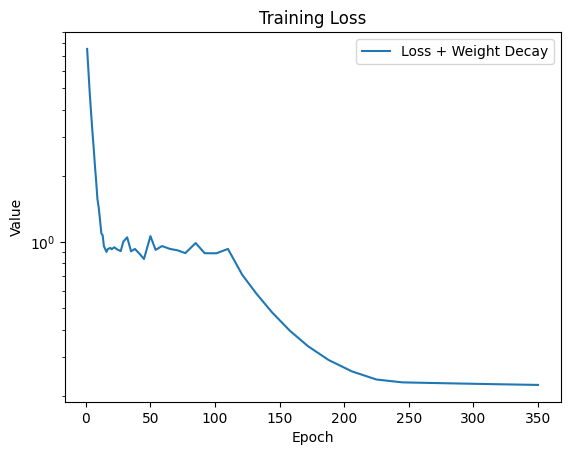

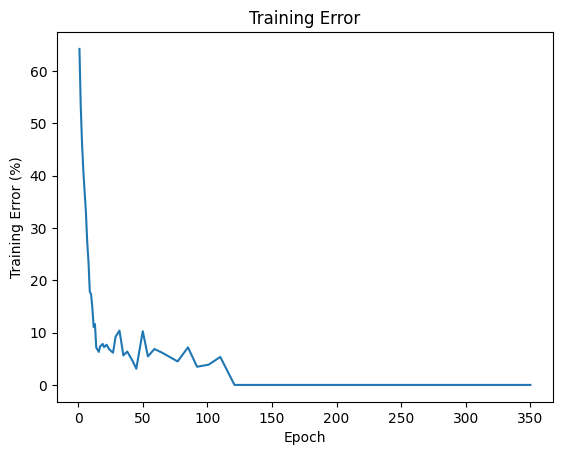

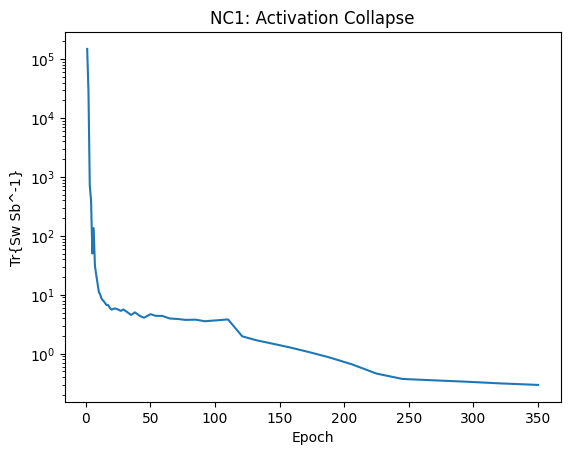

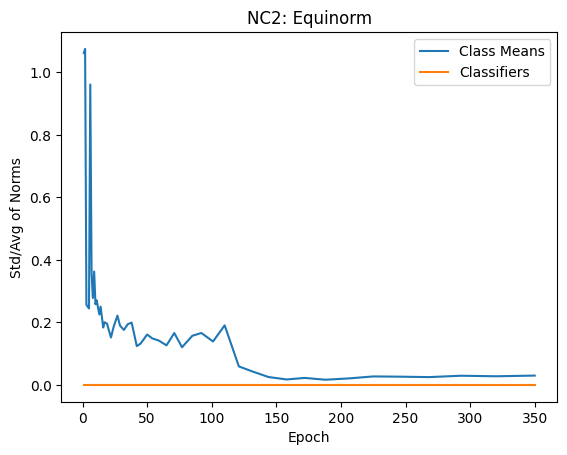

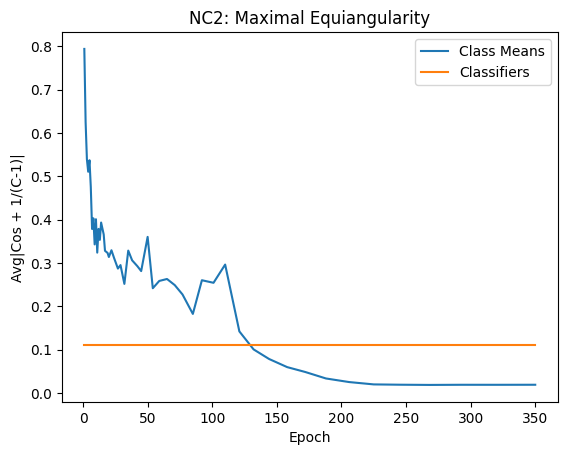

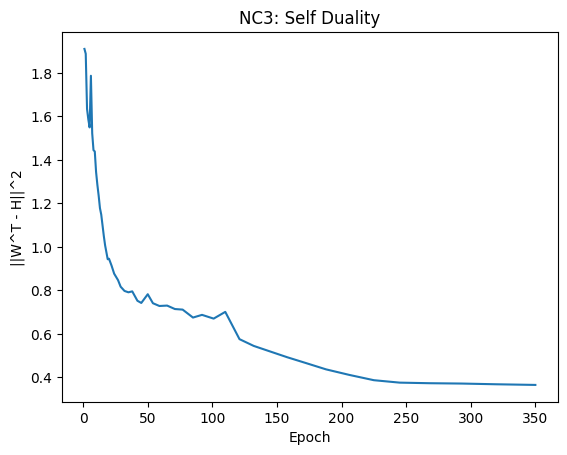

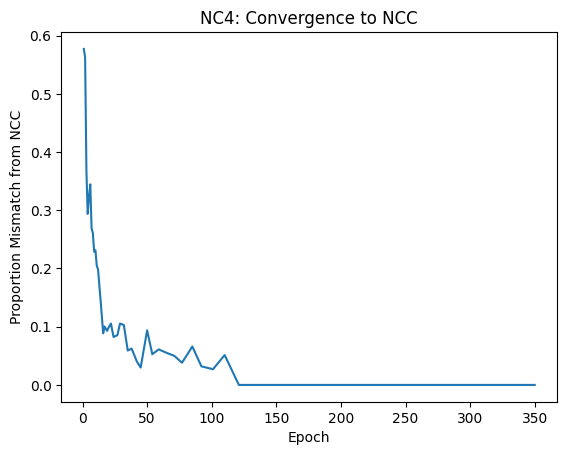

In [ ]:
# transform = transforms.Compose([transforms.Pad((padded_im_size - im_size)//2),
#                                 transforms.ToTensor(),
#                                 transforms.Normalize(0.1307,0.3081)])

# train_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True, transform=transform),
#     batch_size=batch_size, shuffle=True)

# analysis_loader = torch.utils.data.DataLoader(
#     datasets.MNIST('../data', train=True, download=True, transform=transform),
#     batch_size=batch_size, shuffle=True)

from torch.utils.data import Dataset

class ImbalancedCIFAR10(Dataset):
    def __init__(self, dataset):
        self.dataset = dataset
        self.indices = self.make_indices()

    def make_indices(self):
        targets = torch.tensor([target for _, target in self.dataset], dtype=torch.int64)
        class_count = [0] * 10
        for label in targets:
            class_count[label] += 1

        large_class_indices = [i for i, label in enumerate(targets) if label < 5]
        small_class_indices = [i for i, label in enumerate(targets) if label >= 5]

        imbalance_factor = 10  # large classes are 10 times the size of small classes
        small_class_count = len(small_class_indices) // imbalance_factor

        # Keep all samples from large classes
        indices = large_class_indices
        # Keep only a fraction of samples from small classes
        indices += small_class_indices[:small_class_count * imbalance_factor]

        return indices

    def __getitem__(self, index):
        return self.dataset[self.indices[index]]

    def __len__(self):
        return len(self.indices)



transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
])

trainset = torchvision.datasets.CIFAR10('../data', train=True,
                                        download=True, transform=transform)
# train_loader = torch.utils.data.DataLoader(trainset, batch_size=128,
#                                           shuffle=True)

imbalanced_trainset = ImbalancedCIFAR10(trainset)
train_loader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=128, shuffle=True)
analysis_loader = torch.utils.data.DataLoader(imbalanced_trainset, batch_size=128,shuffle=True)


criterion = nn.CrossEntropyLoss()
criterion_summed = nn.CrossEntropyLoss(reduction='sum')

optimizer = optim.SGD(model.parameters(),
                      lr=lr,
                      momentum=momentum,
                      weight_decay=weight_decay)

lr_scheduler = optim.lr_scheduler.MultiStepLR(optimizer,
                                              milestones=epochs_lr_decay,
                                              gamma=lr_decay)

class graphs:
  def __init__(self):
    self.accuracy     = []
    self.loss         = []
    self.reg_loss     = []

    # NC1
    self.Sw_invSb     = []

    # NC2
    self.norm_M_CoV   = []
    self.norm_W_CoV   = []
    self.cos_M        = []
    self.cos_W        = []

    # NC3
    self.W_M_dist     = []

    # NC4
    self.NCC_mismatch = []

graphs = graphs()

cur_epochs = []
for epoch in range(1, epochs + 1):
    train(model, criterion, device, C, train_loader, optimizer, epoch)
    lr_scheduler.step()

    if epoch in epoch_list:
        cur_epochs.append(epoch)
        analysis(graphs, model, criterion_summed, device, C, analysis_loader)

plt.figure(1)
plt.semilogy(cur_epochs, graphs.reg_loss)
plt.legend(['Loss + Weight Decay'])
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss')

plt.figure(2)
plt.plot(cur_epochs, 100*(1 - np.array(graphs.accuracy)))
plt.xlabel('Epoch')
plt.ylabel('Training Error (%)')
plt.title('Training Error')

plt.figure(3)
plt.semilogy(cur_epochs, graphs.Sw_invSb)
plt.xlabel('Epoch')
plt.ylabel('Tr{Sw Sb^-1}')
plt.title('NC1: Activation Collapse')

plt.figure(4)
plt.plot(cur_epochs, graphs.norm_M_CoV)
plt.plot(cur_epochs, graphs.norm_W_CoV)
plt.legend(['Class Means','Classifiers'])
plt.xlabel('Epoch')
plt.ylabel('Std/Avg of Norms')
plt.title('NC2: Equinorm')

plt.figure(5)
plt.plot(cur_epochs, graphs.cos_M)
plt.plot(cur_epochs, graphs.cos_W)
plt.legend(['Class Means','Classifiers'])
plt.xlabel('Epoch')
plt.ylabel('Avg|Cos + 1/(C-1)|')
plt.title('NC2: Maximal Equiangularity')

plt.figure(6)
plt.plot(cur_epochs,graphs.W_M_dist)
plt.xlabel('Epoch')
plt.ylabel('||W^T - H||^2')
plt.title('NC3: Self Duality')

plt.figure(7)
plt.plot(cur_epochs,graphs.NCC_mismatch)
plt.xlabel('Epoch')
plt.ylabel('Proportion Mismatch from NCC')
plt.title('NC4: Convergence to NCC')

plt.show()

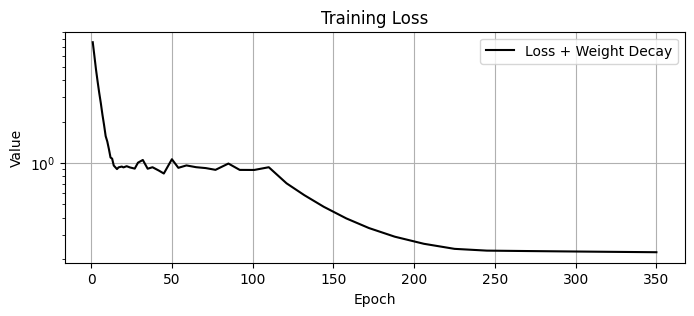

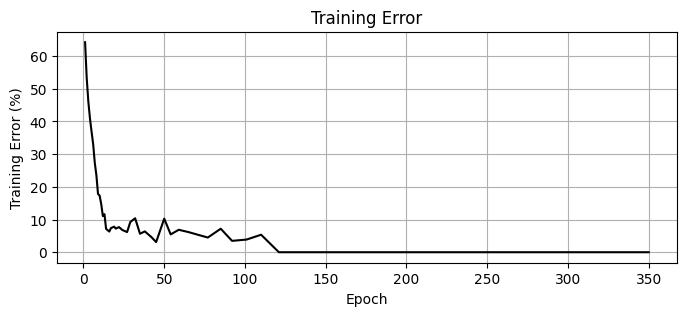

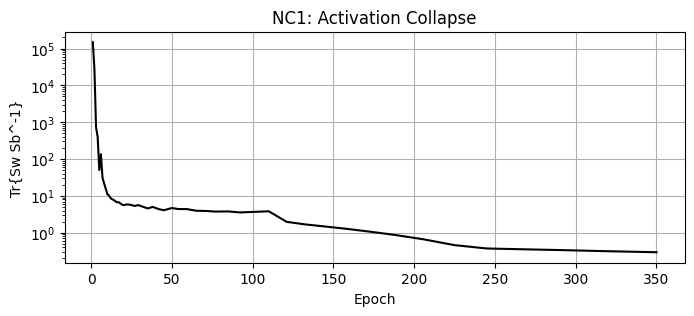

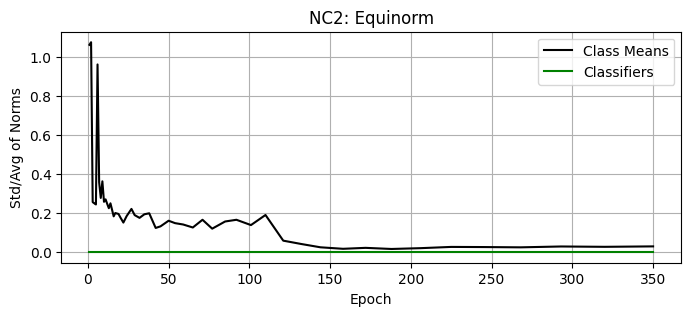

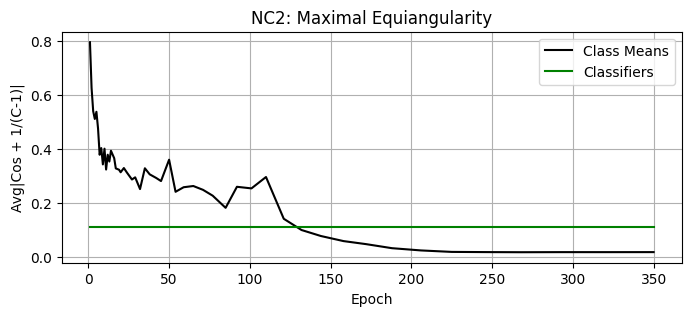

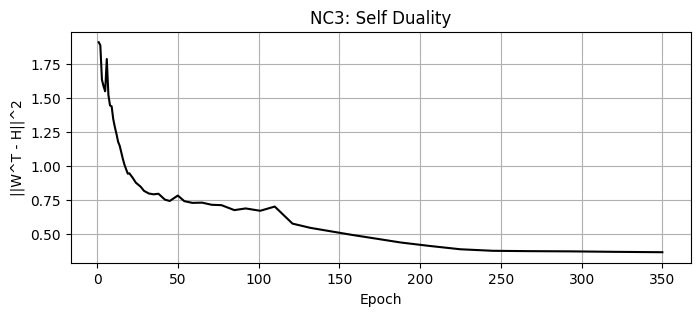

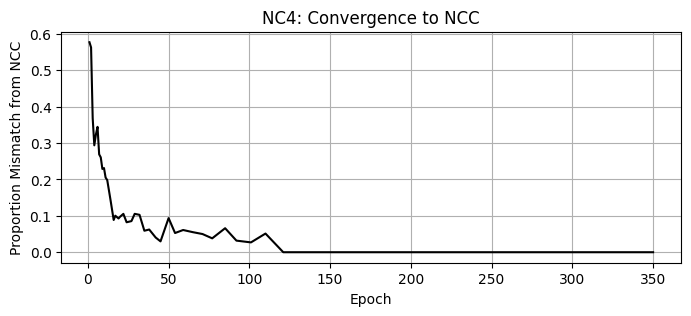

In [ ]:
def plot_graphs(x, y, legend_labels, xlabel, ylabel, title, logscale=False, grid=True):
    fig = plt.figure(figsize=(8, 3))  # Adjust the size of the figure
    colors = ['k', 'g', 'purple']  # Define the colors
    for i in range(len(y)):
        if logscale:
            plt.semilogy(x, y[i], color=colors[i])
        else:
            plt.plot(x, y[i], color=colors[i])
    if legend_labels: # Add this line
        plt.legend(legend_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    return fig

cur_epochs = epoch_list  # Assuming cur_epochs equals to epoch_list

fig1 = plot_graphs(cur_epochs, [graphs.reg_loss], ['Loss + Weight Decay'], 'Epoch', 'Value', 'Training Loss', logscale=True)
fig2 = plot_graphs(cur_epochs, [100*(1 - np.array(graphs.accuracy))], [], 'Epoch', 'Training Error (%)', 'Training Error')  # Replace None with []
fig3 = plot_graphs(cur_epochs, [graphs.Sw_invSb], [], 'Epoch', 'Tr{Sw Sb^-1}', 'NC1: Activation Collapse', logscale=True)  # Replace None with []
fig4 = plot_graphs(cur_epochs, [graphs.norm_M_CoV, graphs.norm_W_CoV], ['Class Means','Classifiers'], 'Epoch', 'Std/Avg of Norms', 'NC2: Equinorm')
fig5 = plot_graphs(cur_epochs, [graphs.cos_M, graphs.cos_W], ['Class Means','Classifiers'], 'Epoch', 'Avg|Cos + 1/(C-1)|', 'NC2: Maximal Equiangularity')
fig6 = plot_graphs(cur_epochs, [graphs.W_M_dist], [], 'Epoch', '||W^T - H||^2', 'NC3: Self Duality')  # Replace None with []
fig7 = plot_graphs(cur_epochs, [graphs.NCC_mismatch], [], 'Epoch', 'Proportion Mismatch from NCC', 'NC4: Convergence to NCC')  # Replace None with []

plt.show()


Mounted at /content/drive


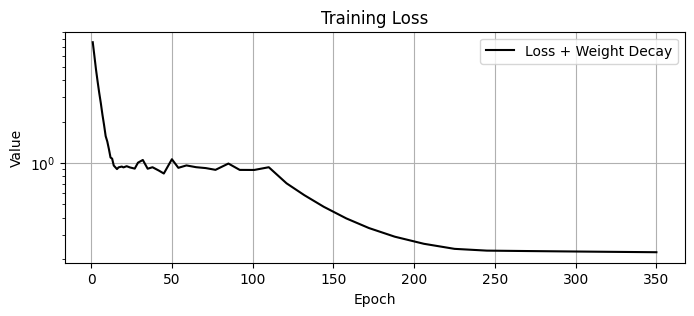

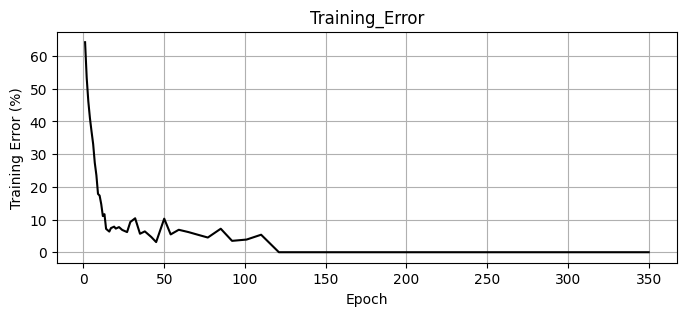

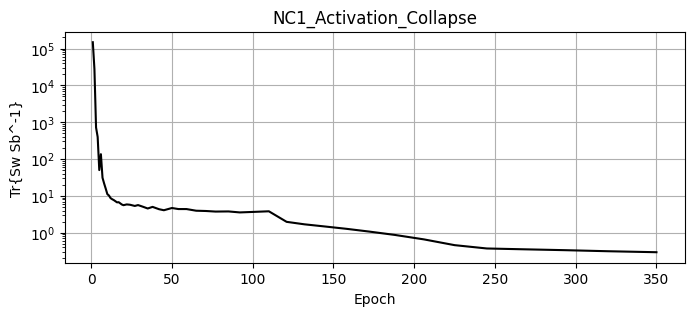

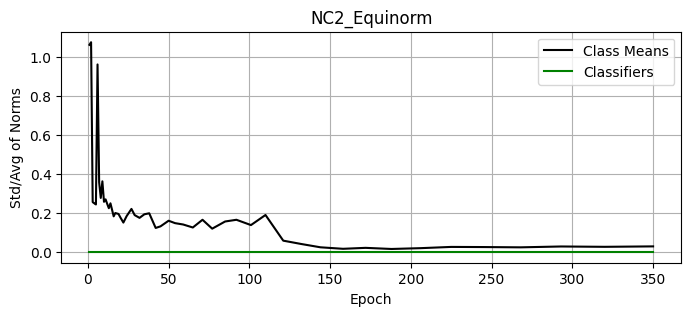

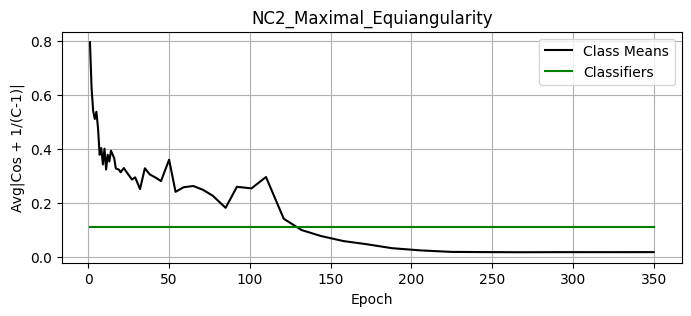

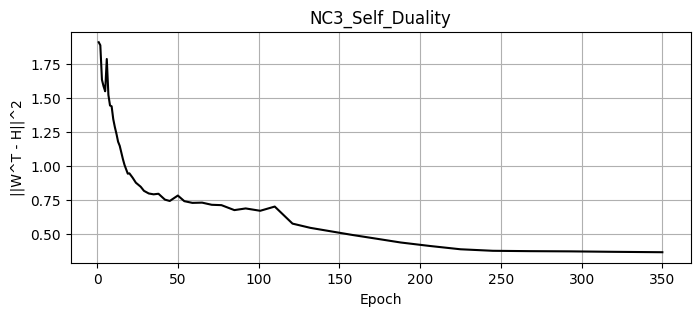

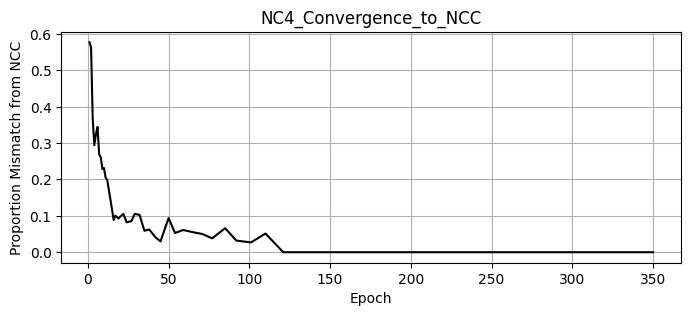

In [ ]:
import pandas as pd
from google.colab import drive

def plot_graphs(x, y, legend_labels, xlabel, ylabel, title, filename, logscale=False, grid=True):
    fig = plt.figure(figsize=(8, 3))  # Adjust the size of the figure
    colors = ['k', 'g', 'purple']  # Define the colors
    for i in range(len(y)):
        if logscale:
            plt.semilogy(x, y[i], color=colors[i])
        else:
            plt.plot(x, y[i], color=colors[i])
    if legend_labels:
        plt.legend(legend_labels)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(grid)
    plt.savefig(filename + '.png')  # Save figure
    return fig

# Assuming cur_epochs equals to epoch_list
cur_epochs = epoch_list

fig1 = plot_graphs(cur_epochs, [graphs.reg_loss], ['Loss + Weight Decay'], 'Epoch', 'Value', 'Training Loss', 'Training_Loss', logscale=True)
fig2 = plot_graphs(cur_epochs, [100*(1 - np.array(graphs.accuracy))], [], 'Epoch', 'Training Error (%)', 'Training_Error', 'Training_Error')
fig3 = plot_graphs(cur_epochs, [graphs.Sw_invSb], [], 'Epoch', 'Tr{Sw Sb^-1}', 'NC1_Activation_Collapse', 'NC1_Activation_Collapse', logscale=True)
fig4 = plot_graphs(cur_epochs, [graphs.norm_M_CoV, graphs.norm_W_CoV], ['Class Means','Classifiers'], 'Epoch', 'Std/Avg of Norms', 'NC2_Equinorm', 'NC2_Equinorm')
fig5 = plot_graphs(cur_epochs, [graphs.cos_M, graphs.cos_W], ['Class Means','Classifiers'], 'Epoch', 'Avg|Cos + 1/(C-1)|', 'NC2_Maximal_Equiangularity', 'NC2_Maximal_Equiangularity')
fig6 = plot_graphs(cur_epochs, [graphs.W_M_dist], [], 'Epoch', '||W^T - H||^2', 'NC3_Self_Duality', 'NC3_Self_Duality')
fig7 = plot_graphs(cur_epochs, [graphs.NCC_mismatch], [], 'Epoch', 'Proportion Mismatch from NCC', 'NC4_Convergence_to_NCC', 'NC4_Convergence_to_NCC')

# Save data as CSV
data = {
    'epochs': epoch_list,
    'reg_loss': graphs.reg_loss,
    'accuracy': graphs.accuracy,
    'Sw_invSb': graphs.Sw_invSb,
    'norm_M_CoV': graphs.norm_M_CoV,
    'norm_W_CoV': graphs.norm_W_CoV,
    'cos_M': graphs.cos_M,
    'cos_W': graphs.cos_W,
    'W_M_dist': graphs.W_M_dist,
    'NCC_mismatch': graphs.NCC_mismatch
}

df = pd.DataFrame(data)

# Mount Google Drive
drive.mount('/content/drive')
path = '/content/drive/MyDrive/output.csv'

# Write DataFrame to CSV file on Google Drive
with open(path, 'w', encoding='utf-8-sig') as f:
    df.to_csv(f, index=False)
